# Setup

In [1]:
%tensorflow_version 2.x

import tensorflow as tf
from tensorflow import keras
print("tf version {0} executing eagerly is {1}".format(tf.__version__, tf.executing_eagerly()))

import tensorflow_probability as tfp
print("tfp version {0}".format(tfp.__version__))

tf version 2.2.0-rc3 executing eagerly is True
tfp version 0.10.0-rc0


In [2]:
from google.colab import drive
drive.mount('/content/drive')
BASE_DIR = '/content/drive/My Drive/StoicNetData/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
USE_GPU = True
if USE_GPU:
    device_name = tf.test.gpu_device_name()
    print("Device name: \"{0}\"".format(device_name))
    if device_name != '/device:GPU:0':
        
        raise SystemError('GPU device not found')
    print('Found GPU at: {}'.format(device_name))

    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)

Device name: "/device:GPU:0"
Found GPU at: /device:GPU:0
1 Physical GPUs, 1 Logical GPUs


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import cv2
import sys
import os
import time
import math
import numpy as np
import glob
import PIL
import imageio
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython import display

import warnings
warnings.simplefilter('error', UserWarning)
warnings.filterwarnings("error")

In [0]:
tf.random.set_seed(98475651423)

# Data

In [0]:
IMG_HEIGHT = 112
IMG_WIDTH = 112

CK_keys_to_features = {
    'image_neutral': tf.io.FixedLenFeature([], tf.string),
    'image_expressive': tf.io.FixedLenFeature([], tf.string),
    'image_other': tf.io.FixedLenFeature([], tf.string)
}

LFW_keys_to_features = {
    'image': tf.io.FixedLenFeature([], tf.string)
}

def parserLFW(record):
    parsed = tf.io.parse_single_example(record, LFW_keys_to_features)
    
    image = tf.io.decode_raw(parsed["image"], tf.uint8)
    image = tf.cast(image, tf.float32)
    image = tf.reshape(image, shape=[224,224,1])
    image = tf.image.resize(image, size=[IMG_HEIGHT,IMG_WIDTH])
    image /= (255/2)
    image -= 1
    
    return {"image":image}
    
def parserCK(record):
    parsed = tf.io.parse_single_example(record, CK_keys_to_features)
    
    imageNeutral = tf.io.decode_raw(parsed["image_neutral"], tf.uint8)
    imageExpressive = tf.io.decode_raw(parsed["image_expressive"], tf.uint8)
    imageOther = tf.io.decode_raw(parsed["image_other"], tf.uint8)
    
    imageNeutral = tf.cast(imageNeutral, tf.float32)
    imageExpressive = tf.cast(imageExpressive, tf.float32)
    imageOther = tf.cast(imageOther, tf.float32)
    
    imageNeutral = tf.reshape(imageNeutral, shape=[224,224,1])
    imageExpressive = tf.reshape(imageExpressive, shape=[224,224,1])
    imageOther = tf.reshape(imageOther, shape=[224,224,1])

    imageNeutral = tf.image.resize(imageNeutral, size=[IMG_HEIGHT,IMG_WIDTH])
    imageExpressive = tf.image.resize(imageExpressive, size=[IMG_HEIGHT,IMG_WIDTH])
    imageOther = tf.image.resize(imageOther, size=[IMG_HEIGHT,IMG_WIDTH])

    imageNeutral /= (255/2)
    imageExpressive /= (255/2)
    imageOther /= (255/2)
    imageNeutral -= 1
    imageExpressive -= 1
    imageOther -= 1

    return {"imageNeutral":imageNeutral, "imageExpressive":imageExpressive, "imageOther":imageOther}
    #return {"image":imageExpressive}


In [0]:
BUFFER_SIZE = 20000
BATCH_SIZE = 32
latent_dim = 100

DB_PATH = BASE_DIR


raw_LFW_train = tf.data.TFRecordDataset(DB_PATH + "trainLFW.tfrecords")
raw_LFW_test = tf.data.TFRecordDataset(DB_PATH + "testLFW.tfrecords")

raw_CK_train = tf.data.TFRecordDataset(DB_PATH + "train.tfrecords")
raw_CK_test = tf.data.TFRecordDataset(DB_PATH + "test.tfrecords")
#raw_CK_val = raw_test.shard(2,0)
#raw_CK_test = raw_test.shard(2,1)

raw_novel = tf.data.TFRecordDataset(DB_PATH + "novel.tfrecords")


parsed_LFW_train = raw_LFW_train.map(parserLFW)
parsed_LFW_test = raw_LFW_test.map(parserLFW)


parsed_CK_train = raw_CK_train.map(parserCK)
#parsed_CK_val = raw_val.map(parserCK)
parsed_CK_test = raw_CK_test.map(parserCK)

parsed_train = parsed_CK_train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
parsed_test  = parsed_CK_test.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

parsed_novel = raw_novel.map(parserCK)

# Model

In [0]:
init = tf.random_normal_initializer(mean=0.0, stddev=0.02, seed=918273645)

class Encoder(tf.keras.Model):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.latent_dim = latent_dim
        self.encode = tf.keras.models.Sequential(layers=[
            tf.keras.layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),

            tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2,2), use_bias=False, kernel_initializer=init),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2,2), use_bias=False, kernel_initializer=init),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(2,2), use_bias=False, kernel_initializer=init),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=(2,2), use_bias=False, kernel_initializer=init),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim + latent_dim, kernel_initializer=init), # no activation...
        ], name="encode")
    
    @tf.function
    def __call__(self, x):
        mean, logvar = tf.split(self.encode(x), num_or_size_splits=2, axis=1)
        return mean, logvar


class Transformer(tf.keras.Model):
    def __init__(self, latent_dim):
        super(Transformer, self).__init__()
        self.latent_dim = latent_dim
        self.transform = tf.keras.models.Sequential(layers=[
            tf.keras.layers.InputLayer(input_shape=(latent_dim)),
            tf.keras.layers.Dense(latent_dim, use_bias=True, kernel_initializer=init), # no activation...
        ], name="transform")

    @tf.function
    def __call__(self, z):
        return self.transform(z)

class Decoder(tf.keras.Model):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.latent_dim = latent_dim
        self.decode = tf.keras.models.Sequential(layers=[
            tf.keras.layers.InputLayer(input_shape=(latent_dim)),

            tf.keras.layers.Dense(units=7*7*256),
            tf.keras.layers.Reshape(target_shape=(7, 7, 256)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2DTranspose(
                filters=128, kernel_size=4, strides=(2, 2), padding="SAME", use_bias=False, kernel_initializer=init),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=4, strides=(2, 2), padding="SAME", use_bias=False, kernel_initializer=init),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=4, strides=(2, 2), padding="SAME", use_bias=False, kernel_initializer=init),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2DTranspose(
                filters=16, kernel_size=4, strides=(2, 2), padding="SAME", use_bias=False, kernel_initializer=init),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=(1, 1), padding="SAME", use_bias=False, kernel_initializer=init,
                activation="tanh"),
        ], name="decode")

    @tf.function
    def __call__(self, z):
        return self.decode(z)


class Enhancer(tf.keras.Model):
    def __init__(self, num_filters):
        super(Enhancer, self).__init__()
        self.num_filters = num_filters
        self.grow = tf.keras.models.Sequential(layers=[
            tf.keras.layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),

            tf.keras.layers.Conv2D(
                filters=num_filters, kernel_size=3, strides=(1, 1), padding="SAME", use_bias=False, kernel_initializer=init),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.PReLU(),
        ], name="grow")

        self.enhance1 = tf.keras.models.Sequential(layers=[
            tf.keras.layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, num_filters)),

            tf.keras.layers.Conv2DTranspose(
                filters=num_filters, kernel_size=3, strides=(1,1), padding="SAME", use_bias=False, kernel_initializer=init),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.PReLU(),

            tf.keras.layers.Conv2DTranspose(
                filters=num_filters, kernel_size=3, strides=(1, 1), padding="SAME", use_bias=False, kernel_initializer=init),
            tf.keras.layers.BatchNormalization(),
        ], name="enhance1")
            
        self.add1 = tf.keras.layers.Add()

        self.enhance2 = tf.keras.models.Sequential(layers=[
            tf.keras.layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, num_filters)),
            tf.keras.layers.PReLU(),

            tf.keras.layers.Conv2DTranspose(
                filters=num_filters, kernel_size=3, strides=(1,1), padding="SAME", use_bias=False, kernel_initializer=init),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.PReLU(),

            tf.keras.layers.Conv2DTranspose(
                filters=num_filters, kernel_size=3, strides=(1, 1), padding="SAME", use_bias=False, kernel_initializer=init),
            tf.keras.layers.BatchNormalization(),
        ], name="enhance2")

        self.add2 = tf.keras.layers.Add()

        self.shrink = tf.keras.models.Sequential(layers=[
            tf.keras.layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, num_filters)),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=(1, 1), padding="SAME", use_bias=False, kernel_initializer=init,
                activation="tanh"),
        ], name="shrink")

    @tf.function
    def __call__(self, x):
        x = self.grow(x)
        y = self.enhance1(x)
        x = self.add1([x, y])
        y = self.enhance2(x)
        x = self.add2([x, y])
        out = self.shrink(x)
        return out

@tf.function
def generateImgSame(x):
    z, _ = encoder(x)
    return enhancer(decoder(z))

@tf.function
def generateImgNeutral(x):
    z, _ = encoder(x)
    z = transformer(z)
    return enhancer(decoder(z))


In [0]:
class Critic(tf.keras.Model):
    def __init__(self):
        super(Critic, self).__init__()
        self.critique = tf.keras.models.Sequential(layers=[
            tf.keras.layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),

            tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2,2), kernel_initializer=init),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),

            tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2,2), kernel_initializer=init),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),

            tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(2,2), kernel_initializer=init),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),

            tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=(2,2), kernel_initializer=init),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(512, kernel_initializer=init),
            tf.keras.layers.LeakyReLU(),

            tf.keras.layers.Dense(1, activation='linear', kernel_initializer=init),     # MAY WANT TO HAVE KEPT THIS AS LINEAR ACTIVATION
        ], name="critique")
    
    @tf.function
    def __call__(self, x):
        return self.critique(x)

# Loss

In [0]:
@tf.function
def add_noise(x):
    noise_intensity = 1.0
    noise = tf.multiply(noise_intensity, tf.random.normal(shape=x.shape, mean=0.0, stddev=0.3))
    return tf.clip_by_value(tf.add(x, noise), -1.0, 1.0)


@tf.function
def compute_apply_gradients(trans, x_n, x_e, transOptimizer):
    with tf.GradientTape(persistent=True) as tape:
        rln, rle = compute_loss(trans, x_n, x_e)
        transLoss = rln + rle

    gradients_of_trans = tape.gradient(transLoss, trans.trainable_variables)
    transOptimizer.apply_gradients(zip(gradients_of_trans, trans.trainable_variables))


@tf.function
def compute_loss(trans, x_n, x_e):
    z_n, _ = encoder(x_n)
    z_e, _ = encoder(x_e)
    #img_n = enhancer(decoder(z_n))
    
    z_tn = trans(z_n)
    z_te = trans(z_e)
    
    # Compare both transformed encodings with neutral encoding
    rln = mse(z_n, z_tn)
    rle = mse(z_n, z_te)

    return rln, rle

@tf.function
def mse(actual, generated):
    return tf.reduce_mean(tf.math.square(tf.math.subtract(actual, generated)))

# I/O

In [0]:
def display_imgs(test_input, epoch=-1):
    im_same = generateImgSame(test_input[0:8])
    im_neut = generateImgNeutral(test_input[0:8])
    ims = np.concatenate((test_input[0:8], im_same, im_neut), axis=0)
    assert not np.any(np.isnan(ims))
    fig, axes = plt.subplots(nrows=3, ncols=8, figsize=(11,4))
    for i in range(ims.shape[0]):
        c = i % 8
        r = i // 8
        axes[r, c].imshow(ims[i, :, :, 0], cmap='gray')
        axes[r, c].set_yticklabels([])
        axes[r, c].xaxis.set_visible(False)
    axes[0,0].set_ylabel("Inputs", size='large')
    axes[1,0].set_ylabel("Generated", size='large')
    axes[2,0].set_ylabel("Neutralized", size='large')
    
    fig.tight_layout()
    if epoch >= 0:
        plt.savefig('gens_at_epoch_{:04d}.png'.format(epoch))
        plt.close(fig)
    else:
        plt.show()


def plot_ALL_loss(ls):
    rln, rle = zip(*ls)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.yaxis.tick_right()
    plt.plot(rln, '-g', label='rLn')
    plt.plot(rle, '-r', label='rLe')
    plt.title("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()



In [0]:
def save_Transformer(prefix, full=False):
    if prefix is None:
        path_to_save = BASE_DIR + "saved_model"
    else:
        path_to_save = BASE_DIR + "saved_model/{}".format(prefix)
    !mkdir -p "{path_to_save}"
    print('Saving transformer at "{}"'.format(path_to_save))
    if full:
        transformer.save(path_to_save + "/transformer.h5")
    else:
        transformer.save_weights(path_to_save + "/transformer.h5")


def load_Transformer(prefix):
    if prefix is None:
        path_to_save = BASE_DIR + "saved_model"
    else:
        path_to_save = BASE_DIR + "saved_model/{}".format(prefix)
 
    transformer.load_weights(path_to_save + "/transformer.h5")
    

def load_StoicNet(prefix, loadTransformer=False):
    if prefix is None:
        path_to_save = BASE_DIR + "saved_model"
    else:
        path_to_save = BASE_DIR + "saved_model/{}".format(prefix)
    
    encoder.load_weights(path_to_save + "/encoder.h5")
    if loadTransformer:
        transformer.load_weights(path_to_save + "/transformer.h5")
    decoder.load_weights(path_to_save + "/decoder.h5")
    enhancer.load_weights(path_to_save + "/enhancer.h5")
    critic.load_weights(path_to_save + "/critic.h5")

# Training

In [13]:
num_examples_to_generate = 16

random_images_for_generation = [image_features['imageExpressive'] for image_features in parsed_test.take(1)][0][0:num_examples_to_generate]
#random_images_for_generation = [image_features['image'] for image_features in parsed_test.take(1)][0][0:num_examples_to_generate]
print("random inputs generated")

random inputs generated


In [14]:
epochs = 100

transOptimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
print("transformer optimizer created")

encoder = Encoder(latent_dim); print("encoder built")
transformer = Transformer(latent_dim); print("transformer built")
decoder = Decoder(latent_dim); print("decoder built")
enhancer = Enhancer(num_filters=32); print("enhancer built")
critic = Critic()
load_StoicNet("FINAL_SAVE_Best"); print("StoicNet loaded")


transformer optimizer created
encoder built
transformer built
decoder built
enhancer built
StoicNet loaded


In [15]:
FRESH = True
if not FRESH:
    load_Transformer("TEMP_SAVE")
    startEpoch = 50
    print("Training loaded transformer from epoch {}".format(startEpoch))
else:
    print("Training a fresh transformer")
    startEpoch = 0

Training a fresh transformer


Epoch 67, Total epoch time 21.4
Losses: rn 0.00568  re 0.02992


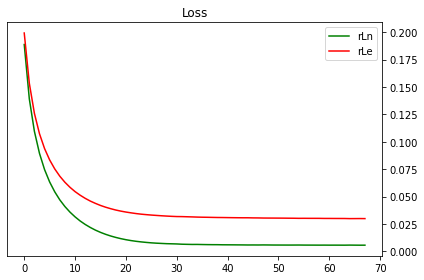

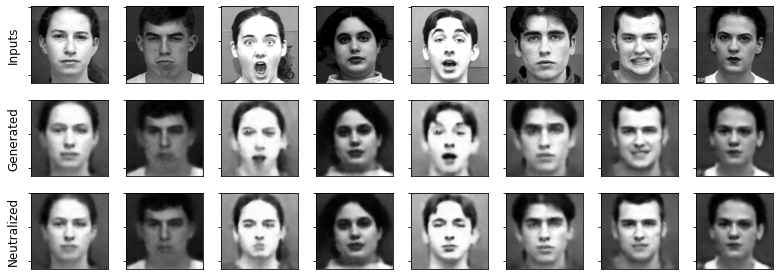

Saving transformer at "/content/drive/My Drive/StoicNetData/saved_model/TEMP_BEST_MODEL"
*Saved new best*

Training All..............................................
Testing All.......

KeyboardInterrupt: ignored

In [0]:
ls = []
bestLoss = 999999.9
start_time = time.time()
for epoch in range(startEpoch, epochs):
    print("\nTraining All", end="")
    batchCounter = 0
    for image_features in parsed_train:
        image_neutral = image_features['imageNeutral']
        image_expressive = image_features['imageExpressive']

        compute_apply_gradients(
            transformer,
            image_neutral, image_expressive,
            transOptimizer)

        batchCounter += 1
        if batchCounter % 10 == 0:
            print(".", end="")
    
    # Test
    print("\nTesting All", end="")
    batchCounter = 0
    rnloss = tf.keras.metrics.Mean()
    reloss = tf.keras.metrics.Mean()
    for image_features in parsed_test:
        image_neutral = image_features['imageNeutral']
        image_expressive = image_features['imageExpressive']

        rln, rle = compute_loss(
            transformer,
            image_neutral, image_expressive)
        
        rnloss(rln)
        reloss(rle)

        batchCounter += 1
        if batchCounter % 10 == 0:
            print(".", end="")

    rln = rnloss.result().numpy()
    rle = reloss.result().numpy()
    ls = ls + [(rln, rle)]
    
    end_time = time.time()

    # Output
    display.clear_output(wait=False)
    print('Epoch {0}, Total epoch time {1:.1f}'.format(epoch, end_time-start_time))
    print('Losses: rn {0:.5f}  re {1:.5f}'.format(
            rln, rle))
    plot_ALL_loss(ls)
    display_imgs(random_images_for_generation)

    # Save the model from time to time or if you get a new record (after sufficient training)
    if epoch > 10 and rln + rle < bestLoss:
        bestLoss = rln + rle
        save_Transformer("TEMP_BEST_MODEL")
        print("*Saved new best*")
    if (epoch + 1) % 5 == 0:
        save_Transformer("TEMP_SAVE")

    tf.keras.backend.clear_session()
    start_time = time.time()

# Save & Test

In [0]:
saveName = "FINAL_SAVE_"+time.strftime('%l_%M_%b%d')

In [0]:
save_Transformer(saveName)

Saving transformer at "/content/drive/My Drive/StoicNetData/saved_model/FINAL_SAVE_ 4_55_Apr18"


In [0]:
display_feature_changes(epoch="FINAL")
display_feature_changes(epoch="good guy test", base=random_images_for_generation[1])
display_feature_changes(epoch="good girl test", base=random_images_for_generation[5])

In [0]:
load_StoicNet("FINAL_SAVE_Best")
load_Transformer("FINAL_SAVE_Best")

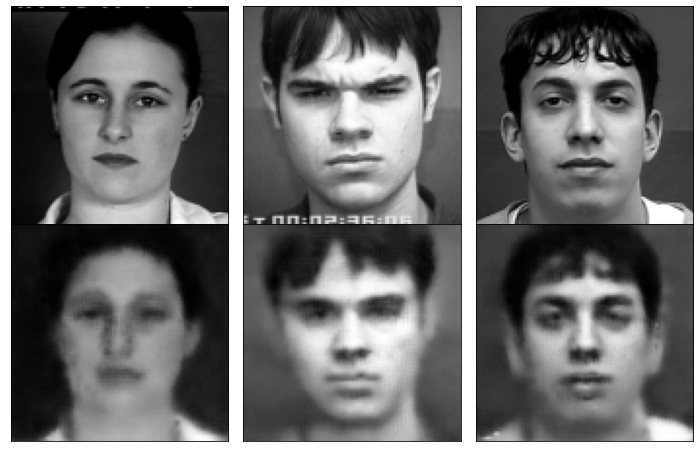

KeyboardInterrupt: ignored

In [24]:
def output_imgs(im_in, scale=1, save=False):
    width = im_in.shape[0]
    im_in = im_in[0:width]
    im_neut = generateImgNeutral(im_in)
    ims = np.concatenate((im_in, im_neut), axis=0)
    ims += 1
    ims *= (255/2)
    assert not np.any(np.isnan(ims))

    fig, axes = plt.subplots(nrows=2, ncols=width, figsize=(width*scale+0.5, 2*scale), gridspec_kw = {'wspace':0, 'hspace':0})
    for i in range(ims.shape[0]):
        c = i % width
        r = i // width
        axes[r, c].imshow(ims[i, :, :, 0], cmap='gray')
        axes[r, c].xaxis.set_visible(False)
        axes[r, c].yaxis.set_visible(False)

    if save:
        plt.savefig('gens_at_epoch_{:04d}.png'.format(epoch))
        plt.close(fig)
    else:
        plt.show()

    choice = input("Enter to continue, type anything to save\n")
    print(choice)
    print(ims.shape)
    if choice != "":
        choice = int(choice)

        realImg = np.squeeze(ims[choice])
        realImg = PIL.Image.fromarray(realImg.astype(np.uint8))
        realImg.save('real.png')

        fakeImg = np.squeeze(ims[choice + width])
        fakeImg = PIL.Image.fromarray(fakeImg.astype(np.uint8))
        fakeImg.save('fake.png')
    


quantity = 3
count = 0
for image_features in parsed_test:
        image_expressive = image_features['imageExpressive']
        for group_index in range(0,math.ceil(BATCH_SIZE/quantity)):
            start = group_index * quantity
            end = min(32,start+quantity)
            images = image_expressive[start:end]
            output_imgs(images, scale=4)
            display.clear_output(wait=True)
#print("yo")